# Chat bot question answering.

The goal of your project is to create a chatbot model that provides answers on client questions.   
Your goal is to divide your dataset on several sections and to make multi-level classifier that will classify the section and later the most reasonable(closest) answer.    
Take care about text-preprocessing, stop words removal, and sentence vectorization

This project consists of the following activities :  




1. Phase 1 : Dataset
    * Team Planning
    * Full git project Integration
    * General Project Research
    * Dataset Collection
    * Dataset Preparation
2. Phase 2 : Training
    * Research about NLP model
    * Compose NLP model
        * Stop words Removal
        * Text tokenization
        * Text Preprocessing
        * Question vectorization
        * Find closest vector
    * Ping Pong phase with Dataset labelers
    * Generate more data if needed
    * Fine tunning of your model


3. Phase 3 : Deployment
    * Perform manual benchmark
    * Model Deploy (Git)
    * Write git Readme.md file
    * Receive Feedback from PM


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
import string
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_fscore_support as score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix, classification_report, confusion_matrix


from bpemb import BPEmb
import xgboost as xgb

%matplotlib inline

Using TensorFlow backend.


# Load Data

In [2]:
brainster_df = pd.read_csv('dataset/dataset_brainster.csv')

In [3]:
brainster_df

,questions,answers,category,category_id
0,Колку време трае академијата за дигитален марк...,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
1,Колку трае академијата за дигитален маркетинг?,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
2,колку месеци недели е академијата за дигитален...,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
3,колку недели е академијата за дигитален маркетинг,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
4,колку месеци е академијата за дигитален маркетинг,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
...,...,...,...,...
2932,Дали добивам диплома по завршување на академиј...,"Ако успешно го одбраниш завршниот проект, доби...",UX/UI,7
2933,дали имам диплома или сертификат за UX/UI,"Ако успешно го одбраниш завршниот проект, доби...",UX/UI,7
2934,дали ќе имам диплома или сертификат на академи...,"Ако успешно го одбраниш завршниот проект, доби...",UX/UI,7
2935,Како ги одбирате студентите на академијата за ...,По средбата или интервјуто координаторот има с...,UX/UI,7


# Provide and prepare data information

In [4]:
questions = brainster_df.questions
other_col = brainster_df.drop(columns='questions', axis=0)

In [5]:
print(questions.shape, other_col.shape)

(2937,) (2937, 3)


In [6]:
other_col.head(5)

,answers,category,category_id
0,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
1,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
2,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
3,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1
4,Академијата за дигитален маркетинг трае 23 нед...,маркетинг,1


In [7]:
questions.head(5)

0    Колку време трае академијата за дигитален марк...
1       Колку трае академијата за дигитален маркетинг?
2    колку месеци недели е академијата за дигитален...
3    колку недели е академијата за дигитален маркетинг
4    колку месеци е академијата за дигитален маркетинг
Name: questions, dtype: object

In [8]:
questions_array = questions.to_numpy()
questions_array

array(['Колку време трае академијата за дигитален маркетинг?',
       'Колку трае академијата за дигитален маркетинг?',
       'колку месеци недели е академијата за дигитален маркетинг', ...,
       'дали ќе имам диплома или сертификат на академијата за UX/UI ',
       'Како ги одбирате студентите на академијата за UX/UI?',
       'Кои се придобивките од посета на Академијата за UX/UI?'],
      dtype=object)

# Data Preprocessing

In [9]:
lat_to_cyr = {'kj' : 'ќ', 'gj' : 'ѓ', 'zh' : 'ж', 'ch' : 'ч', 'sh' : 'ш', 'dj' : 'ѓ',
              'a' : 'а', 'b' : 'б', 'c' : 'ц', 'd' : 'д', 'e' : 'е', 'f' : 'ф', 'g' : 'г',
              'h' : 'х', 'i' : 'и', 'j' : 'ј', 'k' : 'к', 'l' : 'л', 'm' : 'м', 'n' : 'н',
              'o' : 'о', 'p' : 'п', 'q' : 'љ', 'r' : 'р', 's' : 'с', 't' : 'т', 'u' : 'у',
              'v' : 'в', 'w' : 'њ', 'x' : 'џ', 'y' : 'ѕ', 'z' : 'з'
             }

In [10]:
stop_words_mkd = pd.read_csv('stop_words.txt').to_numpy()
stop_words_list = []
for words in stop_words_mkd:
    for word in words:
        stop_words_list.append(word)
        
len(stop_words_list)

171

In [11]:
# input (text) must be array

def text_preprocessed(text, stop_words):
    remove_punctuation = []
    for questions in text:
        lower_case = questions.lower()
        string_punct = str(lower_case).translate(str.maketrans('', '', string.punctuation))
        tokenization = nltk.word_tokenize(string_punct)
        stop_words_removed = []
        for token in tokenization:
            if token not in stop_words:
                stop_words_removed.append(token)
        final = ' '.join(stop_words_removed)
        remove_punctuation.append(final)
    
    questions = []
    for question in remove_punctuation:
        for key, value in lat_to_cyr.items():
            question = re.sub(key, value, question.lower())
        questions.append(question)
    return questions

In [12]:
questions_translated = text_preprocessed(questions_array, stop_words_list)

In [13]:
questions_translated[1:7]

['трае академијата дигитален маркетинг',
 'месеци недели академијата дигитален маркетинг',
 'недели академијата дигитален маркетинг',
 'месеци академијата дигитален маркетинг',
 'долго трае академијата маркетинг',
 'одвива наставата академијата дигитален маркетинг']

# Define Model Architecture

# Count Vectorizer Model

In [14]:
count_vector_model = CountVectorizer(stop_words=stop_words_list, strip_accents='unicode')

In [15]:
count_vector_features = count_vector_model.fit_transform(questions_translated)
questions_df = pd.DataFrame(data = count_vector_features.todense(), 
                            columns=count_vector_model.get_feature_names())

questions_df.tail(10)

C:\Users\Gj\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['веке', 'ке', 'повеке', 'сe'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,15,1630,24,автоматско,адс,акадеимјата,академии,академиите,академија,академијата,...,јава,јазик,јазици,јак,јупѕтер,јљуерѕ,ља,њарехоусе,њебдривер,њебсите
2927,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2928,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2929,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2930,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2931,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2932,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2933,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2934,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2935,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2936,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
questions_df.shape

(2937, 702)

In [17]:
# display function

def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [18]:
display_all(questions_df.head(1))

,15,1630,24,автоматско,адс,акадеимјата,академии,академиите,академија,академијата,академијта,акадмијата,акредитација,акредитиран,акредитирана,активности,алгоритми,анализа,ангажирани,англиски,аплицира,аплицираат,аплицирам,аппиум,асистирате,атрактивна,аутоматед,ајаџ,бази,банкарски,басицс,бацкенд,библиотека,биг,бидам,бидат,бирате,боотстрап,браинстер,број,бусинесс,важи,ваучер,ваучери,ваучерот,ваш,ваша,вашата,ваши,ве,веб,вебсајт,видам,видат,видеа,видеата,видео,види,викенд,вирусот,вклучам,вклучува,владата,внимание,возраст,вработување,време,времетрање,врска,врши,вршите,генератион,гит,гледам,години,гоогле,готово,граница,графички,гроут,гроњтх,група,групата,групи,гугл,давате,дале,дата,датумрок,дебитна,дееп,дел,делот,ден,денови,деновиве,денот,детали,детална,детално,дигитал,дигитален,дигиталниот,дизајн,дизајни,дизајните,диплома,дипломата,добар,добив,добива,добивам,добивање,добиен,добијам,додатни,дознаам,доколку,документ,долго,дополнителни,достапна,достапни,држат,другите,економски,електро,живеам,живо,завршен,завршување,завршувањето,заинтересиран,заинтересирана,замолам,запишам,запишеме,запишуваат,запишување,започнам,започната,започнеме,започнува,здраво,земам,земјава,земјата,знаел,знаење,идејно,избираат,избирате,изведуваат,изработам,изработка,изработуваат,изучува,изучуваат,изучувате,имаат,имам,имаме,имате,инстаграм,инсталирам,инсталирање,инструктори,инструкторите,интеллигенце,интересира,инфо,информации,информација,исконтактирам,искористи,искусни,искуство,исполнувам,ит,кажете,каква,какви,какво,каков,камера,канал,кандидати,кандидатите,кариерен,картичка,керас,клиенти,книги,кого,колкав,колкава,колкави,компании,компетентен,компјутер,компјутери,компјутерот,конкретно,контакт,контактирам,контент,концепирана,копирајтинг,користам,користат,користи,корона,короната,кошта,кратки,кратко,крај,крајниот,крајот,кредит,кредитна,креирање,купам,купи,курс,курсеви,курсевите,лап,лаптоп,лаптопот,ларавел,лаѕоут,леад,леарн,леарнинг,лето,лејаут,линкдин,линкедин,листа,литература,лица,лого,луге,мавен,маил,макдеонски,македонија,македонски,маркетинг,марктинг,математика,мачине,машински,машинско,мегународно,ментори,месеци,места,место,минати,мининг,мк,млади,мое,можам,можат,можност,можностите,мокен,молам,моменталната,мрежи,надвор,намаление,намалување,наменет,наменета,наогаат,наогате,направам,направи,напреден,напредна,напредни,напредувал,населба,насочам,настава,наставата,науки,начин,начини,наши,нашите,најважно,најдам,најдобро,најмалку,најмногу,невронски,недели,неделно,некого,некои,немам,неопходно,нетњоркс,неурал,ниво,нлп,нов,нуди,нудите,обврски,област,областа,области,обработуваат,обука,обуката,објектно,одбивте,одбиен,одбираат,одбирате,одвива,одвиваат,одговор,одговоривте,одлука,одлучам,однос,односно,одржува,одржуваат,онлајн,онлине,онлинепреку,ооп,опрема,опфака,опфатен,опфатот,опција,општествени,организирате,ориентирано,останати,оф,официјалните,оценка,оценува,оценување,пазарот,пакување,пари,партиципирам,партнер,партнери,пат,пати,пајтон,перспективи,перформанси,плака,плакам,плакање,плакањето,платам,плати,побарам,податоци,подготвам,подготвителна,подготвителната,подготовка,поддршка,подобра,подразбира,подразбора,подротвителна,позадина,поздрав,познавања,познавање,полна,помагате,помегу,помогне,помогнете,помош,пополнета,попоуст,попуп,попуст,поради,поразговарам,поразговарм,поректите,портфолио,посветува,поседувам,посета,посредувате,посредување,постер,постои,поточно,потребен,потребна,потребни,потребно,почетник,почетници,почетокот,почнала,почнам,почне,почнува,почнуваат,почнувате,појаснување,поњерби,правам,прават,правата,правен,правење,правите,пракса,практична,практични,практично,пратете,прашам,прашања,прашувам,прегледам,предава,предавачи,предавачите,предавања,предавањата,предавање,предвидена,предзнаења,предзнаење,предлог,предложам,предложи,предложиме,предлози,предност,предноста,предностите,препорачате,претставува,претходни,претходно,приватни,придобивките,признаваат,признат,призната,приклучам,примен,принципот,припремам,припреми,пристапам,пристапот,прифакаат,прифакате,прифатите,причина,пријавам,

# TF-IDF

In [19]:
tf_idf_model = TfidfVectorizer(stop_words=stop_words_list, strip_accents='unicode')

In [20]:
tf_idf_features = tf_idf_model.fit_transform(questions_translated)
questions_df_tfidf = pd.DataFrame(data = tf_idf_features.todense(), 
                            columns=tf_idf_model.get_feature_names())

questions_df_tfidf.tail(10)

C:\Users\Gj\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['веке', 'ке', 'повеке', 'сe'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,15,1630,24,автоматско,адс,акадеимјата,академии,академиите,академија,академијата,...,јава,јазик,јазици,јак,јупѕтер,јљуерѕ,ља,њарехоусе,њебдривер,њебсите
2927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.196128,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.174625,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178372,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.190618,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.359993,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140392,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.148796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.159828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123285,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# TfidfVectorizer Ngrams

In [21]:
tf_idf_ngram_model = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words_list, strip_accents='unicode')

In [22]:
tf_idf_ngram_features = tf_idf_ngram_model.fit_transform(questions_translated)

questions_df_tfidf_ngram = pd.DataFrame(data = tf_idf_ngram_features.todense(), 
                            columns=tf_idf_ngram_model.get_feature_names())

questions_df_tfidf_ngram.tail(10)

C:\Users\Gj\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['веке', 'ке', 'повеке', 'сe'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,15,15 рати,1630,1630 конкретно,24,24 рати,автоматско,автоматско тестирање,адс,акадеимјата,...,ља следува,ља слободни,ља стекнува,ља странство,ља уплати,ља училница,њарехоусе,њарехоусе академијата,њебдривер,њебсите
2927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2934,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2936,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Test Part

In [23]:
client = text_preprocessed(["на колку рати може да плаќам на data science"], stop_words_list)

In [24]:
client

['рати плаќам дата сциенце']

CountVectorizer

In [25]:
client_count_feature = count_vector_model.transform(client)

TfIdfVectorizer

In [26]:
client_tfidf_feature = tf_idf_model.transform(client)

TfIdfVectorizer Ngram

In [27]:
client_tfidf_ngram_feature = tf_idf_ngram_model.transform(client)

# Define distance between two vectors

In [28]:
def distance_vectors(answer, features, client_feature):
    cosine_function = lambda a, b : round(np.inner(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)), 3)
    distances = []
    for vector in features.toarray():
        for clietn_vector in client_feature.toarray():
            cosine = cosine_function(vector, clietn_vector)
            distances.append(cosine)
    index = np.argmax(distances)
    max_cosine = max(distances)
    return answer.answers[index], index, max_cosine   

# Example :  
   Find the closest dataset question based on user defined question

In [29]:
client

['рати плаќам дата сциенце']

In [30]:
cv_answer, cv_index, cv_cosine = distance_vectors(other_col, count_vector_features, client_count_feature)

In [31]:
print("Most equal answer :", cv_answer)
print('Raw number', cv_index)
print('Cosine coefficient:', cv_cosine)

Most equal answer : Data Science е интердисциплинарно поле во кое се применуваат научни методи, процеси, алгоритми и системи за извлекување на корисно знаење и информации од структуирани и неструктуирани податоци.  Data Science  подразбира примена на знаење од областса на Machine learning, Python, Big Data, Business Inteligence, SQL, математика и статистика.
Raw number 1742
Cosine coefficient: 0.707


In [32]:
tfidf_answer, tfidf_index, tfidf_cosine = distance_vectors(other_col, tf_idf_features, client_tfidf_feature)

In [33]:
print("Most equal answer :", tfidf_answer)
print('Raw number', tfidf_index)
print('Cosine coefficient:', tfidf_cosine)

Most equal answer : Ве молиме за детални информации обратете се на контакт телефонот 070/384-728
Raw number 2070
Cosine coefficient: 0.863


In [34]:
ngram_answer, ngram_index, ngram_cosine = distance_vectors(other_col, tf_idf_ngram_features, client_tfidf_ngram_feature)

In [35]:
print("Most equal answer :", ngram_answer)
print('Raw number', ngram_index)
print('Cosine coefficient:', ngram_cosine)

Most equal answer : Moже да се плаќа на 15 месечни рати без камата
Raw number 634
Cosine coefficient: 0.661


# Word Embbeding

In [36]:
bpemb_mk = BPEmb(lang="mk", dim=300)

In [37]:
questions_translated[1:5]

['трае академијата дигитален маркетинг',
 'месеци недели академијата дигитален маркетинг',
 'недели академијата дигитален маркетинг',
 'месеци академијата дигитален маркетинг']

In [38]:
#cos_sim = np.argmax(cosine_similarity([vector],embed_questions))

In [39]:
def result_embed(questions, clinet_question, stop_words):
# embeding of question from dataset
    embed_questions = []
    for question in questions:
        embed_questions.append(bpemb_mk.embed(question).mean(axis=0))

# preproccess and ebmeding of client question
    prepared_question = text_preprocessed([clinet_question], stop_words)

    for query in [prepared_question]:
        query_embedding = bpemb_mk.embed(query).mean(axis=0)
        
        # cdist give us how much is the error similarity
        distances = cdist([query_embedding], embed_questions, "cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        
        print("Прашање:", query)
        print("\n======================\n")
        print("\nTop 5 најдобри резултати:\n")

        for idx, distance in results[0:10]:
            print(other_col.answers[idx].strip(),'\n', "(Score: %.4f)" % (1-distance),'\n', "Index: ", idx)
    

In [40]:
result_embed(questions_translated, 'vo koja biblioteka rabotite deep learning', stop_words_list)

Прашање: ['во која библиотека работите дееп леарнинг']



Top 5 најдобри резултати:

Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.8665) 
 Index:  1664
Невронски мрежи е предвидено да се работат во Keras 
 (Score: 0.8524) 
 Index:  1894
Да, невронските мрежи се опфатени во модулот за машинско учење 
 (Score: 0.7292) 
 Index:  1652
Да, невронските мрежи се опфатени во модулот за машинско учење 
 (Score: 0.7044) 
 Index:  1882
Да, невронските мрежи се опфатени во модулот за машинско учење 
 (Score: 0.6396) 
 Index:  1651
Да, невронските мрежи се опфатени во модулот за машинско учење 
 (Score: 0.6046) 
 Index:  1881
На академијата за Data science е предвиден 11 неделен модул посветен на Machine Learning кои ги покрива следните области: supervised и unsupervised learning 
 (Score: 0.5637) 
 Index:  1647
Најчесто користена библиотека е Sci-kit Learn 
 (Score: 0.5561) 
 Index:  1666
Најчесто користена библиотека е Sci-kit Learn 
 (Score: 0.5539) 
 Index:  1896
Најчесто кори

C:\Users\Gj\Anaconda3\lib\site-packages\bpemb\bpemb.py:383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.emb.vectors[ids]


# Classification Model

In [41]:
def dataset_preprocess(X_part, labels):
    embed_questions = []
    for question in X_part:
        embed_questions.append(bpemb_mk.embed(question).mean(axis=0))
    questions_embed = np.array(embed_questions)    
    target = to_categorical(labels)
    
    X_train, X_test, y_train, y_test = train_test_split(questions_embed, target, test_size=0.20, random_state=10)
    
    return X_train, X_test, y_train, y_test
    

In [42]:
X_train, X_test, y_train, y_test = dataset_preprocess(questions_translated, other_col.category_id)

In [43]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2349, 300) (588, 300) (2349, 8) (588, 8)


In [44]:
model = Sequential()

model.add(Dense(256, input_dim=300))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(16))
model.add(Activation('relu'))

model.add(Dense(10))
model.add(Activation('relu'))

model.add(Dense(8))
model.add(Activation('softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)               

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])

In [46]:
my_callback1 = ModelCheckpoint('best_model.pt', verbose=1, save_best_only=True, mode='max', monitor='val_accuracy')
#my_callback2 = EarlyStopping(patience=7)

my_callbacks = [my_callback1]

In [47]:
model.fit(X_train, y_train, batch_size=None,
    epochs=50,
    verbose=1,
    callbacks=my_callbacks,
    validation_split=0.0,
    validation_data=(X_test, y_test),
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1)

Train on 2349 samples, validate on 588 samples
Epoch 1/50
2349/2349 [==============================] - 1s 398us/step - loss: 1.1995 - accuracy: 0.5466 - val_loss: 0.4322 - val_accuracy: 0.8350

Epoch 00001: val_accuracy improved from -inf to 0.83503, saving model to best_model.pt
Epoch 2/50
2349/2349 [==============================] - 1s 215us/step - loss: 0.1845 - accuracy: 0.9391 - val_loss: 0.1037 - val_accuracy: 0.9796

Epoch 00002: val_accuracy improved from 0.83503 to 0.97959, saving model to best_model.pt
Epoch 3/50
2349/2349 [==============================] - 1s 232us/step - loss: 0.0582 - accuracy: 0.9868 - val_loss: 0.0557 - val_accuracy: 0.9881

Epoch 00003: val_accuracy improved from 0.97959 to 0.98810, saving model to best_model.pt
Epoch 4/50
2349/2349 [==============================] - 1s 214us/step - loss: 0.0340 - accuracy: 0.9911 - val_loss: 0.0588 - val_accuracy: 0.9864

Epoch 00004: val_accuracy did not improve from 0.98810
Epoch 5/50
2349/2349 [=====================

2349/2349 [==============================] - 0s 209us/step - loss: 0.0071 - accuracy: 0.9974 - val_loss: 0.0845 - val_accuracy: 0.9881

Epoch 00040: val_accuracy did not improve from 0.98980
Epoch 41/50
2349/2349 [==============================] - 0s 199us/step - loss: 0.0073 - accuracy: 0.9979 - val_loss: 0.0981 - val_accuracy: 0.9881

Epoch 00041: val_accuracy did not improve from 0.98980
Epoch 42/50
2349/2349 [==============================] - 0s 198us/step - loss: 0.0076 - accuracy: 0.9970 - val_loss: 0.0902 - val_accuracy: 0.9881

Epoch 00042: val_accuracy did not improve from 0.98980
Epoch 43/50
2349/2349 [==============================] - 0s 206us/step - loss: 0.0075 - accuracy: 0.9970 - val_loss: 0.0587 - val_accuracy: 0.9881

Epoch 00043: val_accuracy did not improve from 0.98980
Epoch 44/50
2349/2349 [==============================] - 0s 195us/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.0662 - val_accuracy: 0.9898

Epoch 00044: val_accuracy did not improve from 0.989

In [48]:
model.load_weights('best_model.pt')

In [49]:
predict_question = model.predict(X_test)

In [50]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose = 1, callbacks=my_callbacks)
print("Accuracy relu activation: %.2f%%\n" % (scores[1]*100))

588/588 [==============================] - 0s 83us/step
Accuracy relu activation: 98.98%



In [51]:
#Convert predictions to 0/1 vectors
y_pred_relu = np.array([int(np.argmax(predict_question[i])) for i in range(len(predict_question))])
y_test_array = [np.argmax(y_test[i]) for i in range(len(y_test))]

relu_accuracy = (y_pred_relu == y_test_array).mean()

In [52]:
precision, recall, relu_fscore, support = score(y_test_array, y_pred_relu, average='macro')
print(np.round(relu_accuracy, 3), np.round(relu_fscore, 3))


0.99 0.99


Classification Report: relu 
               precision    recall  f1-score   support

           0       0.94      0.96      0.95        53
           1       0.99      1.00      0.99        79
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        70
           4       1.00      0.96      0.98       103
           5       0.99      1.00      1.00       104
           6       0.99      1.00      1.00       117
           7       1.00      1.00      1.00        24

    accuracy                           0.99       588
   macro avg       0.99      0.99      0.99       588
weighted avg       0.99      0.99      0.99       588



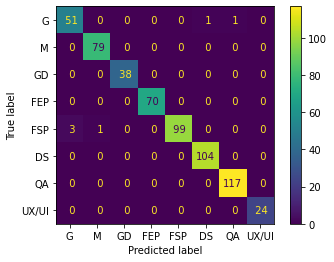

In [53]:
labels = ['G', 'M', 'GD', 'FEP', 'FSP', 'DS', 'QA', 'UX/UI']

cr_we_relu = classification_report(y_test_array, y_pred_relu)
print('Classification Report: relu \n', cr_we_relu)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_array, y_pred_relu),
                              display_labels=labels, )

disp = disp.plot(values_format='3')

plt.show()

In [55]:
def class_predict(client_question, stop_words):
    client_question_embed = bpemb_mk.embed(text_preprocessed([client_question], stop_words)).mean(axis=0)
    question_reshape = client_question_embed.reshape(1, 300)
    class_predict = np.argmax(model.predict(question_reshape))
    print(labels[class_predict])

In [58]:
class_predict('dali uchite keras vo data science', stop_words_list)

DS


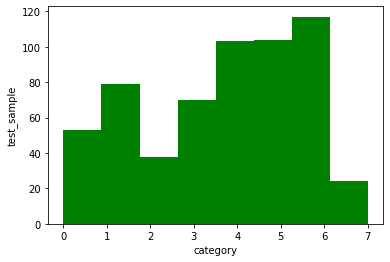

In [59]:
plt.hist(y_test_array, bins=8, color='g' )  
plt.ylabel('test_sample')
plt.xlabel('category')
plt.show()

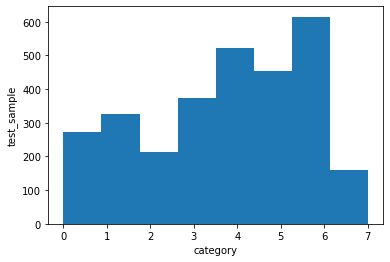

In [60]:
fig, ax = plt.subplots()
ax.hist(other_col.category_id, bins=8)  
plt.ylabel('test_sample')
plt.xlabel('category')
#for tick in ax.get_xticklabels():
#    tick.set_rotation(90)
plt.show()

In [61]:
y_train_array = [np.argmax(y_train[i]) for i in range(len(y_train))]

In [62]:
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train_array)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.94      0.91      0.92        53
           1       1.00      0.99      0.99        79
           2       1.00      1.00      1.00        38
           3       1.00      1.00      1.00        70
           4       1.00      0.96      0.98       103
           5       0.98      1.00      0.99       104
           6       0.97      1.00      0.98       117
           7       0.96      1.00      0.98        24

    accuracy                           0.98       588
   macro avg       0.98      0.98      0.98       588
weighted avg       0.98      0.98      0.98       588



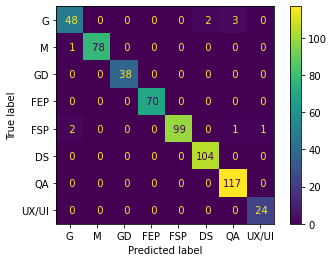

In [63]:
xgb_pred = xgb_classifier.predict(X_test)

#Printing the classification report
xgb_class_report = classification_report(y_test_array, xgb_pred)
print(xgb_class_report)

#confusion_matrix()
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_array, xgb_pred),
                              display_labels=labels)

disp = disp.plot(values_format='3')

plt.show()

In [64]:
def class_predict_xgb(client_question, stop_words):
    q_tr = text_preprocessed([client_question], stop_words)
    client_question_embed = bpemb_mk.embed(q_tr).mean(axis=0)
    question_reshape = client_question_embed.reshape(1, 300)
    class_predict = np.argmax(xgb_classifier.predict(question_reshape))
    print(labels[class_predict])

In [67]:
class_predict_xgb('shto se uchi na akademijata za data science', stop_words_list)

G


In [68]:
prasanje = 'што се учи на академијата за дизајн'

In [69]:
class_predict(prasanje, stop_words_list)

GD


C:\Users\Gj\Anaconda3\lib\site-packages\bpemb\bpemb.py:383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.emb.vectors[ids]


In [70]:
result_embed(questions_translated, prasanje, stop_words_list)

Прашање: ['учи академијата дизајн']



Top 5 најдобри резултати:

На Академијата за графички дизајн предвидено е изучување на дизајн и типографија, работа со соодветен софтвер (Illustrator, Photoshop, Indesign). Знаењето практично се применува на проекти (на пр. дизајн на лого, постер, пакување). 
 (Score: 0.8351) 
 Index:  385
Во Академијата за графички дизајн ќе работите со софтверските пакети Adobe Illustrator, Adobe Photoshop и Adobe Indesign. 
 (Score: 0.7680) 
 Index:  378
Во овој дел ќе работите на дизајн на книга, публикација, списание, корици и слично. 
 (Score: 0.7097) 
 Index:  465
На Академијата за графички дизајн предвидено е изучување на дизајн и типографија, работа со соодветен софтвер (Illustrator, Photoshop, Indesign). Знаењето практично се применува на проекти (на пр. дизајн на лого, постер, пакување). 
 (Score: 0.7064) 
 Index:  380
На Академијата за графички дизајн предвидено е изучување на дизајн и типографија, работа со соодветен софтвер (Illustrator, Photoshop, I

C:\Users\Gj\Anaconda3\lib\site-packages\bpemb\bpemb.py:383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return self.emb.vectors[ids]


# Make Benchmark and provide info

In [71]:
benchmark_questions = ['Колку чини академијата за програмирање?',
'Кога почнува академијата?', 'Дали се работи за време на викенд?', 'Дали ми треба математика?' ,
'Ќе добијам ли сертификат на крајот на академијата?', 'Дали ми треба специјален компјутер за програмирање?'
'Дали целата настава е онлајн?', 'Се учат ли бази на податоци?', 'Дали после академијата ќе можам да се вработам?',
'Кои предзнаења треба да ги имам?']

# Make Summary about your results